In [ ]:
import yfinance as yf
import numpy as np

# TSLA 옵션 데이터를 가져오기
ticker = "TSLA"
tsla = yf.Ticker(ticker)

# 현재 옵션 만기일 가져오기
expiry_dates = tsla.options
expiry = expiry_dates[1]  # 가장 가까운 만기일 선택

# 옵션 체인 가져오기
option_chain = tsla.option_chain(expiry)
calls = option_chain.calls
puts = option_chain.puts

# 현재 TSLA 주가 가져오기
current_price = tsla.history().tail(1)['Close'].iloc[0]

# 현재 주가와 가장 가까운 행사가격 선택 (ATM 옵션)
strike_prices = np.array(sorted(calls['strike'].values))
mid_strike_idx = np.abs(strike_prices - current_price).argmin()
mid_strike = strike_prices[mid_strike_idx]

# 실제 존재하는 ITM, OTM 옵션 찾기 (근처에서 선택)
if mid_strike_idx > 0 and mid_strike_idx < len(strike_prices) - 1:
    low_strike = strike_prices[mid_strike_idx - 1]  # ITM (콜 매수)
    high_strike = strike_prices[mid_strike_idx + 1] # OTM (콜 매수)
else:
    raise ValueError("적절한 버터플라이 스프레드를 구성할 수 없습니다.")

# 해당 행사가격의 옵션 데이터 가져오기 (콜 옵션)
call_low = calls[calls['strike'] == low_strike].iloc[0]
call_mid = calls[calls['strike'] == mid_strike].iloc[0]
call_high = calls[calls['strike'] == high_strike].iloc[0]

# 해당 행사가격의 옵션 데이터 가져오기 (풋 옵션)
put_low = puts[puts['strike'] == low_strike].iloc[0]
put_mid = puts[puts['strike'] == mid_strike].iloc[0]
put_high = puts[puts['strike'] == high_strike].iloc[0]

# 옵션 프리미엄 가져오기
call_low_premium = call_low['lastPrice']
call_mid_premium = call_mid['lastPrice']
call_high_premium = call_high['lastPrice']

put_low_premium = put_low['lastPrice']
put_mid_premium = put_mid['lastPrice']
put_high_premium = put_high['lastPrice']

# 버터플라이 스프레드 비용 계산 (콜 & 풋)
call_butterfly_cost = (call_low_premium + call_high_premium) - (2 * call_mid_premium)
put_butterfly_cost = (put_low_premium + put_high_premium) - (2 * put_mid_premium)

# 최대 이익 및 손실 계산
max_profit = high_strike - mid_strike - call_butterfly_cost
max_loss = call_butterfly_cost

# 결과 출력
print(f"현재 TSLA 주가: {current_price}")
print(f"선택된 만기: {expiry}")
print(f"사용된 행사가격: ITM({low_strike}), ATM({mid_strike}), OTM({high_strike})")
print(f"콜 버터플라이 스프레드 비용: {call_butterfly_cost}")
print(f"풋 버터플라이 스프레드 비용: {put_butterfly_cost}")
print(f"최대 이익: {max_profit}")
print(f"최대 손실: {max_loss}")


현재 TSLA 주가: 337.79998779296875
선택된 만기: 2025-03-07
사용된 행사가격: ITM(335.0), ATM(340.0), OTM(345.0)
콜 버터플라이 스프레드 비용: 0.16000000000000014
풋 버터플라이 스프레드 비용: 0.19000000000000128
최대 이익: 4.84
최대 손실: 0.16000000000000014


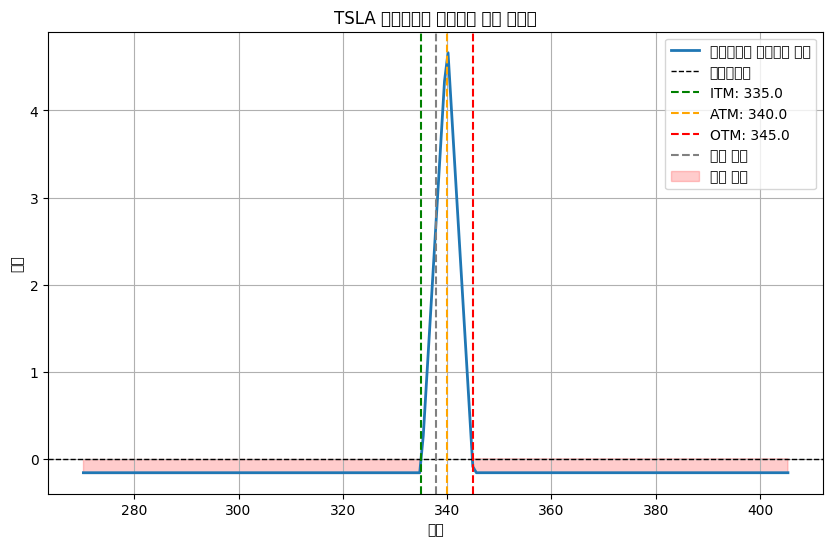

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 변수 설정
strike_prices = [low_strike, mid_strike, high_strike]  # 사용된 행사가격
premium = call_butterfly_cost  # 콜 버터플라이 총 비용
current_price = current_price  # 현재 TSLA 주가

# 주가 범위 설정 (현재 주가의 80% ~ 120%)
price_range = np.linspace(current_price * 0.8, current_price * 1.2, 200)

# 버터플라이 스프레드 손익 계산
profit = np.where(price_range <= low_strike, -premium,
                  np.where(price_range < mid_strike,
                           price_range - low_strike - premium,
                           np.where(price_range < high_strike,
                                    high_strike - price_range - premium,
                                    -premium)))

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(price_range, profit, label='버터플라이 스프레드 수익', linewidth=2)
plt.axhline(0, color='black', linestyle='--', linewidth=1, label="손익분기선")
plt.axvline(low_strike, color='green', linestyle='--', label=f'ITM: {low_strike}')
plt.axvline(mid_strike, color='orange', linestyle='--', label=f'ATM: {mid_strike}')
plt.axvline(high_strike, color='red', linestyle='--', label=f'OTM: {high_strike}')
plt.axvline(current_price, color='gray', linestyle='--', label='현재 주가')

# 손실 구간 음영 처리
plt.fill_between(price_range, profit, where=(profit < 0), color='red', alpha=0.2, label="손실 구간")

# 그래프 설정
plt.title('TSLA 버터플라이 스프레드 수익 그래프')
plt.xlabel('주가')
plt.ylabel('수익')
plt.legend()
plt.grid(True)
plt.show()
